### Tasks - project 4

Identifying regulatory interactions
Single cell RNA sequencing data allows the measurement of all genes in many cells at the same time. Genes are often co-regulated, or regulate each other. Correlation, anti-correlation or mutual information between pairs of genes can hint regulatory interactions, and help in reconstructing regulatory networks.

*	Background single cell RNA sequencing
*	Data – any single cell RNA-sequencing data.
*	Filter out genes that are not expressed
*	Replace values lower than one by one. log2 transform the data
*	Identify pairs of genes that are significantly correlated (alternatively, anti-correlated or have mutual information). Take into account the problem of multiple comparisons
*	Test if those gene pairs are also correlated in the other dataset. 
*	For at least one correlated pair of genes, see if you can find research about interaction or functional relationships between those genes. 


In [2]:
from sys import getsizeof
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mutual_info_score
from scipy.stats.stats import pearsonr   
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [3]:
def calc_MI(x, y, bins=12):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi


def mutual_info_per_df(df, nbins):
    mi_genes = {}
    for i, gen1 in enumerate(df):
        for j, gen2 in enumerate(df):
            if j >= i:
                continue
            val = calc_MI(df[gen1].values.astype(dtype='float'),
                          df[gen2].values.astype(dtype='float'),
                                                   bins=12)
            mi_genes['__'.join([gen1, gen2])] = val
        if i % 40 == 0: print i
    print np.mean(mi_corr.values()), np.std(mi_corr.values())
    return mi_genes


def pre_log2(df):
    for gene in df:
        for ind, val in df[gene].iteritems():
            if val <= 1:
                df.set_value(index=ind, col=gene, value=0)
            elif val > 1:
                df.set_value(index=ind, col=gene, value=np.log2(val))
    return df

def remove_zero_genes(mode, trsh=40):
    cnt = 0
    zeros = []
    for col in tqdm(df):
        if mode == 'zero':
            if (df[col].values < 1).all():
                cnt += 1
                zeros.append(col)            
        elif mode == 'sparse':
            if np.sum((df[col].values > 1)) < 40:        
                cnt += 1
                zeros.append(col)
    print '# removed columns = ', cnt
    df.drop(zeros, axis=1, inplace=True)
    return df

In [4]:
% ls data/

GSE81383_data_melanoma_scRNAseq_BT_Mel.txt
GSE82187_cast_all_forGEO.csv
GSE83533_AML_130_Rel_rpkm.txt
unused/


In [5]:
path = '/Users/mdymshits/comp_bio/data/GSE81383_data_melanoma_scRNAseq_BT_Mel.txt'
df = pd.read_csv(path, delim_whitespace=True).T
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [6]:
df.shape

(307, 19019)

In [7]:
df.iloc[:3,:10]

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC
0,12.5743,0.0,0.000000,0.0,0.0,0.0,0.0,56.0385,1.435230,0.0
1,28.6732,0.0,0.000000,0.0,0.0,0.0,0.0,46.5397,2.173360,0.0
2,24.6465,0.0,0.070888,0.0,0.0,0.0,0.0,0.0000,0.159235,0.0


(0, 2500)

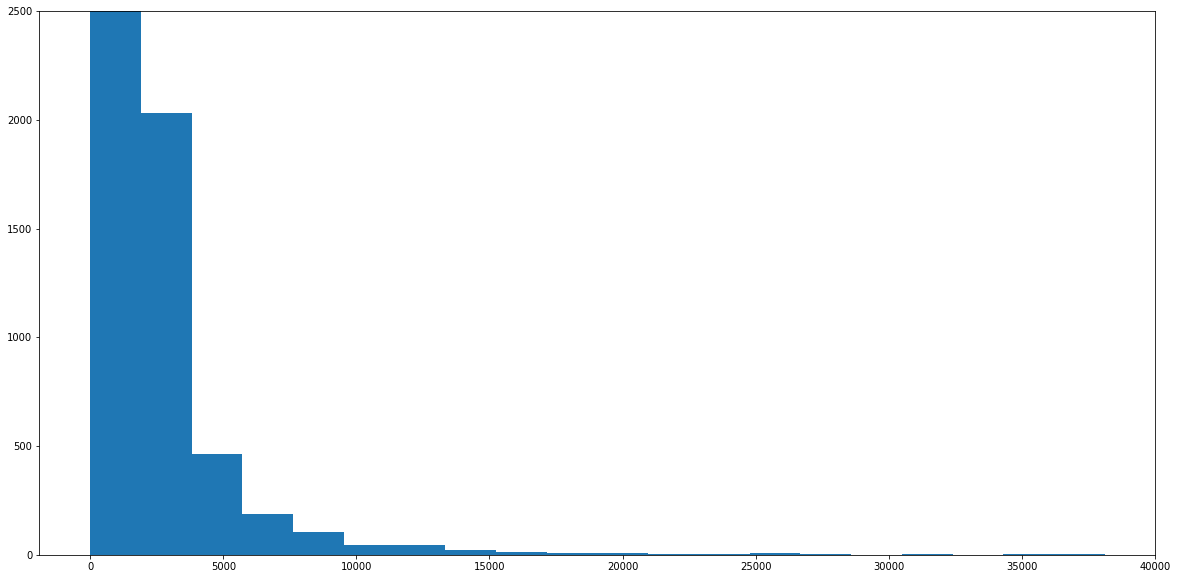

In [8]:
plt.figure(figsize=(20, 10))
# bins = np.linspace(0, .25, 20)
plt.hist(df.values.ravel(), bins=20);
# plt.xlim(0, 20)
plt.ylim(0, 2500)

# Preprocessing with $log_2$

In [9]:
%time df = pre_log2(df)


CPU times: user 30.2 s, sys: 511 ms, total: 30.7 s
Wall time: 30.4 s


In [10]:

df.iloc[:3,:10]



,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC
0,3.652406,0.0,0.0,0.0,0.0,0.0,0.0,5.808346,0.521282,0.0
1,4.841631,0.0,0.0,0.0,0.0,0.0,0.0,5.540390,1.119927,0.0
2,4.623311,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


19019it [00:00, 56843.24it/s]          


# removed columns =  10234


(0, 500000)

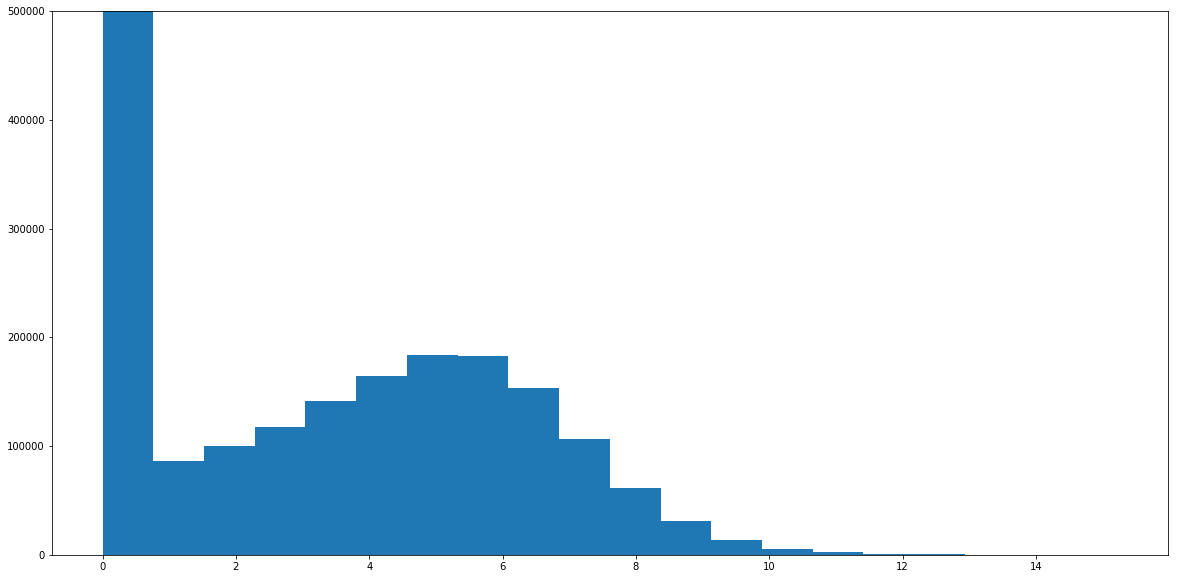

In [11]:
df = remove_zero_genes(mode='sparse')
col_names = df.columns
plt.figure(figsize=(20, 10))
plt.hist(df.values.ravel().astype('float'), bins=20);
plt.ylim(0, 500000)


In [12]:
df.shape

(307, 8785)

In [13]:
df_np = df.values

%time cor = np.corrcoef(df_np.T)

CPU times: user 2.32 s, sys: 173 ms, total: 2.49 s
Wall time: 1.44 s


In [14]:
cor.shape

(8785, 8785)

# Look up for genes with correlation above $0.9$

In [15]:
cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) > .85:
            cor_genes['_'.join([col_names[i], col_names[j]])] = cor[i,j]


100%|██████████| 8785/8785 [00:29<00:00, 294.43it/s]


In [16]:
len(cor_genes)

185

In [17]:
cor_genes['HLA-DRB1_CD74']

0.88180499082167974

In [18]:
non_cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) < .01:
            non_cor_genes['_'.join([col_names[i], col_names[j]])] = cor[i,j]
#             print cor[i,j], col_names[i], col_names[j]

100%|██████████| 8785/8785 [00:37<00:00, 235.32it/s]


In [19]:
len(non_cor_genes) / 10. ** 6

3.150427

# Mutual Information
### $MI = H(X|Y) 	= -\sum_{x,y} p(x,y) \log \frac{p(x,y)}{p(x)p(y)} $

In [20]:
nbins = 25
mi_no_corr = []
for i, key in enumerate(non_cor_genes):
#     print i, key
    gen1, gen2 = key.split('_')
#     print gen1, gen2
    val = calc_MI(df[gen1].values.astype(dtype='float'),
                  df[gen2].values.astype(dtype='float'),
                                             bins=nbins)
    mi_no_corr.append(val)
    if i > 1000:
        break
print np.mean(mi_no_corr), np.std(mi_no_corr)   

0.397842820547 0.138377404442


In [21]:
n_bins=25
mi_corr = {}
for i, key in enumerate(cor_genes):
    gen1, gen2 = key.split('_')
    val = calc_MI(df[gen1].values.astype(dtype='float'),
                  df[gen2].values.astype(dtype='float'),
                                            bins=nbins)
    mi_corr['__'.join([gen1, gen2])] = val

print np.mean(mi_corr.values()), np.std(mi_corr.values())


0.83334241122 0.123160267253


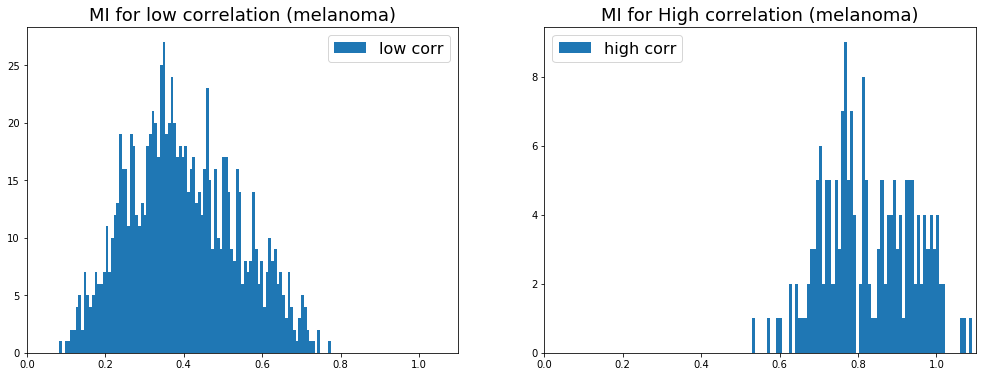

In [37]:
plt.figure(figsize=(17, 6))
plt.subplot(1,2,1)
plt.hist(mi_no_corr, bins= 100, label='low corr');
plt.xlim(0,1.1)
plt.legend(fontsize=16)
plt.title('MI for low correlation (melanoma)', fontsize=18)
plt.subplot(1,2,2)
plt.hist(mi_corr.values(), bins=100, label='high corr');
plt.xlim(0,1.1)
# plt.ylim(0,2 * 10 **3)
plt.legend(fontsize=16)
plt.title('MI for High correlation (melanoma)', fontsize=18)

In [23]:
cor_genes

{'BOLA2B_BOLA2': 0.938080832292017,
 'CD74_AXL': 0.87839524805486813,
 'CDH13_AXL': 0.97080037264366836,
 'CDH13_CD74': 0.85504060332409138,
 'CSAG1_AXL': 0.92839435000424719,
 'CSAG1_CDH13': 0.92713188801526036,
 'DHRS3_AXL': 0.88534610856745721,
 'DHRS3_CDH13': 0.86969348376264044,
 'EIF3CL_BOLA2B': 0.87905507596759624,
 'EIF3CL_EIF3C': 0.93474649019603873,
 'EIF3C_BOLA2': 0.86785196569382994,
 'EIF3C_BOLA2B': 0.92597938298624871,
 'FKBP1C_FKBP1A': 0.89772313827513806,
 'GAGE1_AXL': 0.92783977836514142,
 'GAGE1_CDH13': 0.9114528905216388,
 'GAGE1_CSAG1': 0.89457532762400294,
 'GPR143_CDK2': 0.8575725481380807,
 'GPR161_GPR143': 0.87168967994558133,
 'GSTP1_EXOC3': 0.85272569131405973,
 'GSTP1_GPR143': 0.88243073081947709,
 'GSTP1_GPR161': 0.85098460408465748,
 'HIST2H4B_HIST2H4A': 0.99291053284397213,
 'HLA-DRA_AXL': 0.87468691451736336,
 'HLA-DRA_CD74': 0.94684184554104589,
 'HLA-DRB1_AXL': 0.86327736216237749,
 'HLA-DRB1_CD74': 0.88180499082167974,
 'HLA-DRB1_HLA-DRA': 0.8963579573

In [24]:
calc_MI(range(10000),[0] * 10000, bins=200)

1.3877787807814457e-15

In [25]:
path = '/Users/mdymshits/comp_bio/data/GSE83533_AML_130_Rel_rpkm.txt'
df_l = pd.read_csv(path, delimiter='\t')
df_l = df_l.iloc[:, 1:].T
df_l.columns = df_l.iloc[0]
df_l = df_l.reindex(df_l.index.drop('gene'))
df_l.reset_index(inplace=True)
df_l.drop('index', axis=1, inplace=True)
df_l.columns = ['_'.join([col, str(i)]) for i, col in enumerate(df_l.columns)]
df_l = pre_log2(df_l)
df_l.columns = [col.split('_')[0] for col in df_l.columns]
df_l.iloc[:10,:10]

,TAF1L,RNU6-69,ROCK1,SNORD115-42,OR8B2,LYN,SNORD115-43,OR8B3,OR2AT4,KCTD14
0,0,0,5.32214,0,0,2.30855,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,6.14119,0,0,1.51708,0,0,0,0
3,0,0,4.59235,0,0,7.17212,0,0,0,0
4,0,0,1.54127,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,4.86468,0,0,0,0,0,0,0
7,0,0,6.33524,0,0,0,0,0,0,0
8,0,0,4.48762,0,0,0.0175428,0,0,0,0
9,0,0,3.4881,0,0,2.67135,0,0,0,0


# Now let's go back to leukemia datase
## and try to find genes which has a high correlation in "melanoma data set.

In [26]:
for gen_pair in cor_genes:
    g1, g2 = gen_pair.split('_')
    
    if g1 in df_l and g2 in df_l:
        
        if (df_l[g1].values ==0).all() or (df_l[g1].values ==0).all():
            continue
        corr =  pearsonr(df_l[g1].values.astype('float'),
                         df_l[g2].values.astype('float'))[0]
        if abs(corr) > .4:
                print g1, g2, '\n', corr, '\n'

/Users/mdymshits/virtualenv/tf_new/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


S100A6 HLA-DRA 
0.44459282144 

HLA-DRB1 CD74 
0.538788343955 

UQCRHL UQCRH 
0.834276052755 

HLA-DRA CD74 
0.53930617774 

HLA-DRB1 HLA-DRA 
0.49944805205 



# Plot of "similar" genes


In [34]:
n = 20
df['UQCRHL'].plot(figsize=(18,10),);
df['UQCRH'].plot();
plt.title('gene pair plot [UQCRHL UQCRH] melanoma dataset
          ', fontsize=n)
plt.xlabel('cells', fontsize=n);
plt.ylabel('expression level', fontsize=n);

SyntaxError: EOL while scanning string literal (<ipython-input-34-e4f81faed145>, line 4)

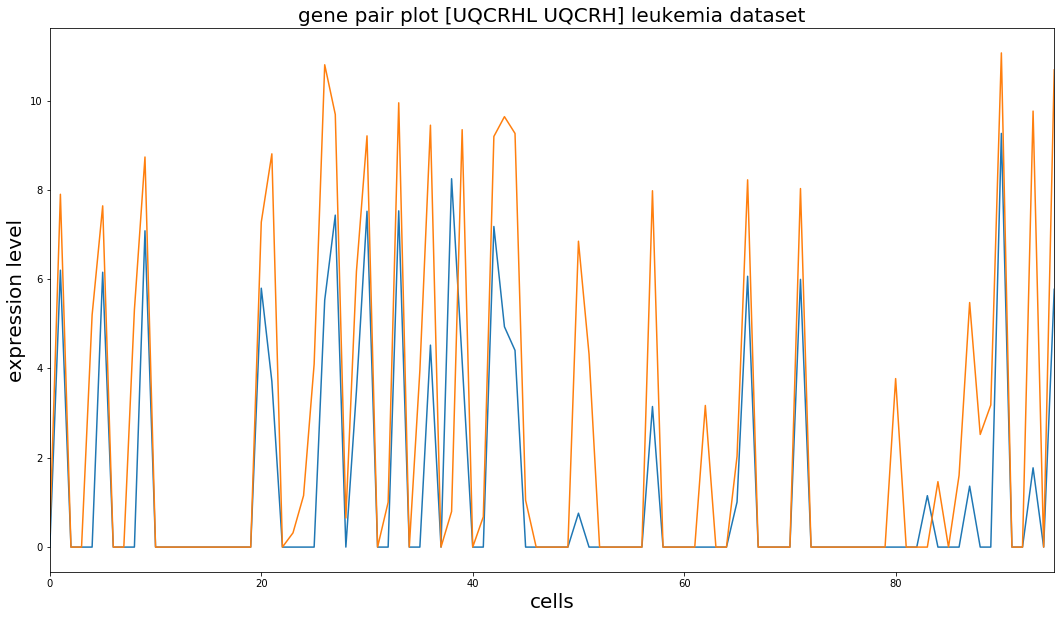

In [33]:
n=20
df_l['UQCRHL'].plot(figsize=(18,10));
df_l['UQCRH'].plot();
plt.title('gene pair plot [UQCRHL UQCRH] leukemia dataset', fontsize=n)
plt.xlabel('cells', fontsize=n);
plt.ylabel('expression level', fontsize=n);

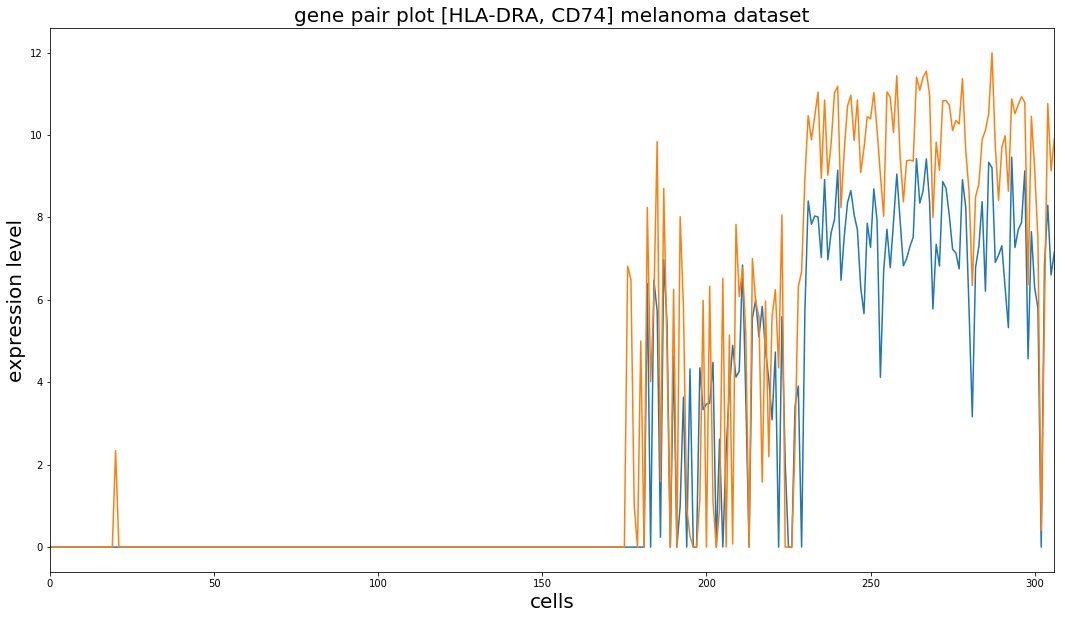

In [40]:
n=20
df['HLA-DRA'].plot(figsize=(18,10));
df['CD74'].plot();
plt.title('gene pair plot [HLA-DRA, CD74] melanoma dataset', fontsize=n)
plt.xlabel('cells', fontsize=n);
plt.ylabel('expression level', fontsize=n);

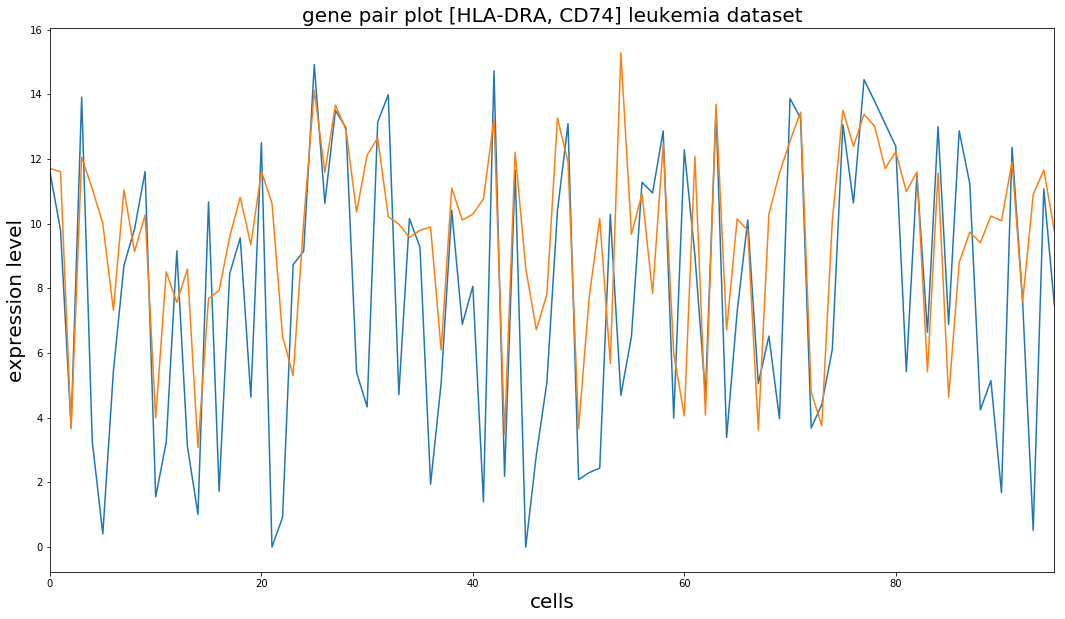

In [38]:
n=20
df_l['HLA-DRA'].plot(figsize=(18,10));
df_l['CD74'].plot();
plt.title('gene pair plot [HLA-DRA, CD74] leukemia dataset', fontsize=n)
plt.xlabel('cells', fontsize=n);
plt.ylabel('expression level', fontsize=n);

In [163]:
for a, b in zip(df_l['UQCRHL'], df_l['UQCRH']):
    if a != 0 and b != 0:
        print a, b

6.20043113434 7.90035690731
6.15468584547 7.64132197283
7.0828173255 8.73514146141
5.7971545617 7.27634943516
3.71207996718 8.80604640829
5.53015928145 10.800626382
7.43323318968 9.68771162924
3.49397439793 6.17034400781
7.52005231166 9.20862333056
7.529422212 9.94877792482
4.52244177575 9.44719901551
8.24862251433 0.797181996665
4.16264370013 9.34680795021
7.17901509721 9.19523470998
4.93362934145 9.63840736651
4.40456735761 9.26295504093
0.758921223488 6.84930332725
3.14785386045 7.97950169581
1.00934019093 2.03363310423
6.06455236492 8.22377485831
5.99461462455 8.02871071288
1.36438527858 5.47614103313
9.26304875253 11.0660759099
1.77506336274 9.76321568378
5.77196183335 10.6860718289


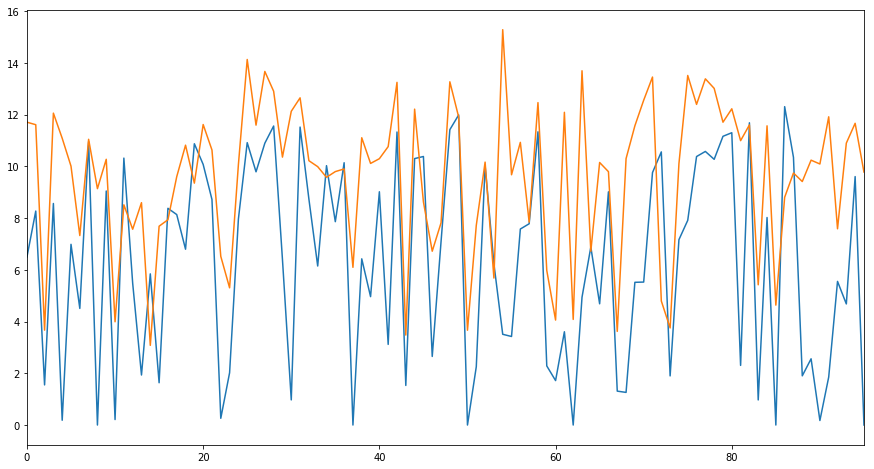

In [174]:
df_l['HLA-DRB1'].plot(figsize=(15,8));
df_l['CD74'].plot();

In [164]:
for a, b in zip(df_l['HLA-DRB1'], df_l['CD74']):
    if a != 0 and b != 0:
        print a, b

6.49619066837 11.7071474641
8.27197932608 11.6102102801
1.5512677487 3.66845128807
8.56443544192 12.0570052123
0.184730986198 11.0870945043
6.98577138007 10.0074589222
4.50814867646 7.32577193397
10.9568195906 11.0457151906
9.04665466575 10.2726184961
0.211832937726 3.99198148982
10.318757447 8.51330219874
5.48213770757 7.56894759789
1.9339112351 8.59541529069
5.84358436718 3.0803495223
1.63459411677 7.68645140826
8.37875673373 7.93492346801
8.13605722177 9.6007149766
6.79664686822 10.8185622269
10.8741583425 9.3509662608
10.0745679913 11.6167965292
8.7177198289 10.6313699742
0.260083749567 6.52022524278
2.02053662445 5.30407855024
7.96250136668 10.0680106633
10.9160379781 14.1314353623
9.78940663396 11.5937291849
10.8951078706 13.6693669796
11.5592027243 12.9031946513
6.40055013211 10.3573432835
0.971594444148 12.1284804076
11.5182033604 12.6488565334
8.73814956038 10.2187735178
6.14762241101 9.9884440129
10.0264686381 9.57669004539
7.86113100031 9.79744736346
10.1402964604 9.89983800

The human leukocyte antigen (HLA) system or complex is a gene complex encoding the major histocompatibility complex (MHC) proteins in humans. These cell-surface proteins are responsible for the regulation of the immune system in humans.